<center><font size=6> xgboost预测实验 </font></center>
主要是考虑能否通过xgboost来找到合适的买点。将价格预测作为2分类问题

流程：
1. 整理训练数据
2. 直接训练

重要：
1. 需要更长的时间历史数据，保留7月的数据用于回测。数据集应该划分为 train/val/test
    - 训练集可以随机采样，但是测试集需要不重合地划分。
2. 看不出交易量是否有用，所以需要做对照试验


结论：

In [1]:
import pandas as pd
import numpy as np

In [2]:
import os

In [3]:
class Data_Loader(object):
    
    def __init__(self):
        pass
    
    def get_price_df(self, file_list):
        '''
        从file_list读取数据，然后以df形式返回。
        '''
        concatenated_df = pd.DataFrame()
        if len(file_list) > 1:
            for temp_file in file_list:
                temp_path = file_path + temp_file
                # 从本地读取价量数据
                temp_price_df = pd.read_csv(temp_path, header=None)
                temp_price_df.columns = ['open_time','open','high','low','close','volume','close_time','quote_volume','count',
                                    'taker_buy_volume','taker_buy_quote_volume','ignore']
                concatenated_df = pd.concat([concatenated_df, temp_price_df])
                
        else:
            temp_file = file_list[0]
            temp_path = file_path + temp_file
            # 从本地读取价量数据
            temp_price_df = pd.read_csv(temp_path, header=None)
            temp_price_df.columns = ['open_time','open','high','low','close','volume','close_time','quote_volume','count',
                                'taker_buy_volume','taker_buy_quote_volume','ignore']
            concatenated_df = temp_price_df
        
        concatenated_df.reset_index(drop=True, inplace=True)
        return concatenated_df
    
    def calculate_theta(self, Boll_df, price_df, target_column_list=["close"]):
        '''
        计算theta指标
        Boll_df: 用于存放指标的df
        price_df：原始价格的df
        '''
        for target_column in target_column_list:
            # theta
            Boll_df['mean_20_'+target_column] = price_df[[target_column]].ewm(span=20, adjust=False).mean()
            Boll_df['std_20_'+target_column] = price_df[[target_column]].ewm(span=20, adjust=False).std()
            Boll_df[target_column] = price_df[target_column]

            # 计算偏离度 theta = (p - ma) / sigma
            Boll_df['theta_'+target_column] = (Boll_df[target_column] - Boll_df['mean_20_'+target_column]) / Boll_df['std_20_'+target_column]

        return Boll_df
    
    def calculate_theta_prospective_earnings(self, price_df):
        '''
        计算预期收益率
        '''
        # 计算未来均价
        price_df['mean_10_future'] = price_df[['close']].ewm(span=10, adjust=False).mean().shift(-10)  # 首先计算均线，然后错位10个（也就是对应于未来的均价）
        # 计算未来收益
        price_df['prospective_earnings'] = (price_df['mean_10_future'] - price_df['close']) / price_df['close']     
        price_df['prospective_earnings_bool'] = price_df['prospective_earnings'] > 0
        price_df['prospective_earnings_1'] = (price_df['close'].shift(-2) - price_df['close']) / price_df['close'] 
        price_df['prospective_earnings_1'] = price_df['prospective_earnings_1'] > 0   # 等于零视为下跌
        return price_df

# 1.数据准备 

In [4]:
import random

In [5]:
file_path = "../data/cc_data/"
file_list = os.listdir(file_path)
file_list = [x if "csv" in x else None for x in file_list] # 排除文件夹
file_list.remove(None)

In [6]:
file_list.remove(None)

In [7]:
data_loader = Data_Loader()

In [8]:
len(file_list)

50

In [9]:
train_df = data_loader.get_price_df(file_list[:40])
test_df = data_loader.get_price_df(file_list[40:])

## 1.1 计算技术指标

In [10]:
train_theta_df = pd.DataFrame()
test_theta_df = pd.DataFrame()

train_theta_df["close"] = train_df["close"]
test_theta_df["close"] = test_df["close"]

target_columns_list = ['open','high','low','close','quote_volume', 'taker_buy_volume', 'taker_buy_quote_volume']  # 需要计算theta的对应列
# target_columns_list = ['close'] 

train_theta_df = data_loader.calculate_theta(train_theta_df, train_df, target_columns_list)
test_theta_df = data_loader.calculate_theta(test_theta_df, test_df, target_columns_list)

train_theta_df.dropna(inplace=True)
test_theta_df.dropna(inplace=True)

## 1.3 采样X和y

In [11]:
train_theta_df = data_loader.calculate_theta_prospective_earnings(train_theta_df)
test_theta_df = data_loader.calculate_theta_prospective_earnings(test_theta_df)

In [12]:
train_theta_df.dropna(inplace=True)
test_theta_df.dropna(inplace=True)

In [38]:
def Sample_random(data_df, target_columns_list, y_columns_list=["prospective_earnings"], sample_num=20, time_range=5):
    '''随机采样'''
    # 采样随机时间点
    X_df = data_df[target_columns_list]
    pandas_concat_list = [X_df.shift(i) for i in range(time_range)]  # 通过将数据合并到同一行，加速采样过程
    pandas_concat_list.append(data_df[y_columns_list])
    concated_data_df = pd.concat(pandas_concat_list, axis=1)
    concated_data_df.dropna(inplace=True)
    concated_data_df.reset_index(inplace=True, drop=True)
    

    index = np.random.permutation(np.arange(0, len(concated_data_df)))  # 按照固定间隔获取索引，并乱序
    random_index = index[:sample_num]
    
    
    sampled_df = concated_data_df.loc[random_index]# 通过切片取出目标X,y
    X_sample = np.array(sampled_df.iloc[:,:-len(y_columns_list)])    # y部分固定在末尾
    y_sample_df = sampled_df[y_columns_list]
    
    assert X_sample.shape[0] == y_sample_df.shape[0] , '采样X与y数量不一致'
    
    return X_sample, y_sample_df

In [39]:
target_x_columns = ["theta_"+x for x in target_columns_list]
target_y_columns = ["prospective_earnings", "prospective_earnings_bool"]

In [40]:
n_train = 500000
n_test =  200000

In [41]:
origin_train_X, origin_train_y = Sample_random(train_theta_df, target_x_columns, target_y_columns, sample_num=n_train)
origin_test_X, origin_test_y = Sample_random(test_theta_df, target_x_columns, target_y_columns, sample_num=n_test)

In [42]:
print("sample_X.shape: ", origin_train_X.shape)
print("sample_y.shape: ", origin_train_y.shape)

sample_X.shape:  (500000, 35)
sample_y.shape:  (500000, 2)


In [43]:
print("sample_test_X.shape: ", origin_test_X.shape)
print("sample_test_y.shape: ", origin_test_y.shape)

sample_test_X.shape:  (200000, 35)
sample_test_y.shape:  (200000, 2)


# 2. 模型训练

In [44]:
from xgboost import XGBClassifier

In [45]:
sample_X, sample_y = origin_train_X, origin_train_y["prospective_earnings_bool"].values
sample_X = sample_X.reshape((len(sample_X),-1))

test_X = origin_test_X.reshape((len(origin_test_X),-1))
test_y = origin_test_y["prospective_earnings_bool"].values

In [46]:
kwars = {
            "eval_metric": "rmse",
            "colsample_bytree": 0.8879,
            "eta": 0.0421,
            "max_depth": 8,
            "n_estimators": 700,
            "subsample": 0.8789,
            "nthread": 20,
}

xgbc_model = XGBClassifier(**kwars)

In [47]:
from collections import Counter

In [48]:
xgbc_model.fit(sample_X, sample_y)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.8879, eta=0.0421,
              eval_metric='rmse', gamma=0, gpu_id=-1, importance_type='gain',
              interaction_constraints='', learning_rate=0.0421000011,
              max_delta_step=0, max_depth=8, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=700, n_jobs=20,
              nthread=20, num_parallel_tree=1, objective='binary:logistic',
              random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
              subsample=0.8789, tree_method='exact', validate_parameters=1,
              verbosity=None)

# 3. 模型评价

In [49]:
from sklearn.metrics import f1_score, roc_curve, recall_score, precision_score, auc
import matplotlib.pyplot as plt

预测的正例数： 100952
测试集合正例数： 99610
f1_score(特殊计算)： 0.5544420179296178
recall_score(故障被找到率)： 0.558176889870495
precision_score(预测故障时，确实故障率)： 0.5507567953086615


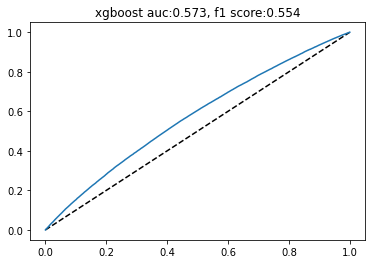

In [50]:
# xgboost 的roc曲线

Y_pred = xgbc_model.predict_proba(test_X)[:, 1]
Y_pred_lab = xgbc_model.predict(test_X)
fpr, tpr, thresholds = roc_curve(test_y, Y_pred)
roc_auc = auc(fpr, tpr)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.title(f'xgboost auc:{roc_auc :.3f}, f1 score:{f1_score(test_y, Y_pred_lab) :.3f}')

print('预测的正例数：',Y_pred_lab.sum())
print('测试集合正例数：', test_y.sum())

print('f1_score(特殊计算)：', f1_score(test_y, Y_pred_lab))
print('recall_score(故障被找到率)：', recall_score(test_y, Y_pred_lab))
print('precision_score(预测故障时，确实故障率)：', precision_score(test_y, Y_pred_lab))

In [51]:
origin_test_y[Y_pred_lab].prospective_earnings.mean() * 100

0.019142218065240794

In [52]:
origin_test_y[~Y_pred_lab].prospective_earnings.mean()* 100

-0.017134150826945405